# Car rental

A small car rental company has a fleet of 94 vehicles distributed among its 10 agencies. The location of every agency is given by its geographical coordinates X and Y in a grid based on kilometers. We assume that the road distance between agencies is approximately 1.3 times the Euclidean distance (as the crow flies). The following table indicates the coordinates of all agencies, the number of cars required the next morning, and the stock of cars in the evening preceding this day.

Supposing the cost for transporting a car is $0.50 per km, determine the movements of cars that allow the company to re-establish the required numbers of cars at all agencies, minimizing the total cost incurred for transport.

### Mathematical Programming Model
##### Sets:
- $A$: Agencies with more cars than demand.
- $B$ Agencies with more demand than cars.

##### Inputs:
- $c$: Fixed transportation cost per car per kilometer.
- $d_{ab}$: Distance between two agencies $a$ and $b$, $a \in A, b \in B$.
- $r$: Agencies that require cars.
- $p$: Agencies that quantity of cars present exceeds required cars.


##### Objective Function: Minimize the total cost of transportin cars.
$$\text{min} \sum_{a \in A} \sum_{b \in B}c d_{ab} x_{ab}$$

##### Decision Variables:
$x_{ab}$: Flow between the two agencies, i.e. Quantity of cars to go from agency $a$ to agency $b$. $x_{ab} \in \mathbb{Z}_{+} \cup \{0\}$

##### Constraints:
1. **Excess:** Every agency with an excess number of cars needs to get rid of these.
$$ \sum_{b \in B} x_{ab} = p_{a} - r_{a} \quad \forall a \in A$$

2. **Need:** Every agency in need of car has to complete its fleet by receiving the missing number.
$$ \sum_{a \in A} x_{a,b} = r_{b} - p_{b} \quad \forall b \in B $$

In [1]:
import pyomo.environ as pyo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Carga de datos
data = pd.read_excel("./data/car_rental.xlsx", index_col=0)
data

,X_coord,Y_coord,Required_Cars,Cars_Present,Fixed_Cost,Distance_Factor
Agency,,,,,,
1,0,0,10,8,0.5,1.3
2,20,20,6,13,NaN,NaN
3,18,10,8,4,NaN,NaN
4,30,12,11,8,NaN,NaN
5,35,0,9,12,NaN,NaN
6,33,25,7,2,NaN,NaN
7,5,27,15,14,NaN,NaN
8,5,10,7,11,NaN,NaN
9,11,0,9,15,NaN,NaN


In [3]:
def matrixDistance(data, x_coord, y_coord, factor=1):
    """
    Function that computes the Euclidean distance between two agencies.
    Args:
        data: Dataset containing the coordinates of the agencies.
        x_coord: Column of coordinates along the x-axis.
        y_coord: Column of coordinates along the y-axis.
        factor: Scaling factor for estimating the Euclidean distance and the actual distance.
    Return:
        data_dist: Dataset containing the distance between agencies.
    """
    data = data.copy()
    data_dist = pd.DataFrame()
    agencies = data.index
    for agency1 in agencies:
        for agency2 in agencies:
            x1 = data.loc[agency1, x_coord]
            y1 = data.loc[agency1, y_coord]
            x2 = data.loc[agency2, x_coord]
            y2 = data.loc[agency2, y_coord]
            xi = (x2 - x1) ** 2
            yi = (y2 - y1) ** 2
            dist = factor*(np.sqrt(xi + yi))
            data_dist.loc[agency1, agency2] = dist
    return data_dist

In [4]:
# Agencies with more cars present than required cars
A = data[data["Required_Cars"] <= data["Cars_Present"]].index

# Agencies with more required cars than cars present
B = data[data["Cars_Present"] < data["Required_Cars"]].index 

# Required cars
r = data["Required_Cars"]

# Cars present
p = data["Cars_Present"]

# Fixed transportation cost per car per kilometer
c = data.loc[1, "Fixed_Cost"]

# Estimation factor for Euclidean Distance
f = data.loc[1, "Distance_Factor"] 

# Euclidean distance between agencies
d = matrixDistance(data, "X_coord", "Y_coord", factor=f) 

In [5]:
d

,1,2,3,4,5,6,7,8,9,10
1,0.000000,36.769553,26.768638,42.004285,45.500000,53.820628,35.696779,14.534442,14.300000,19.672570
2,36.769553,0.000000,13.257451,16.648123,32.500000,18.106905,21.518829,23.436083,28.511226,24.286004
3,26.768638,13.257451,0.000000,15.815183,25.640008,27.577164,27.821215,16.900000,15.868522,21.791971
4,42.004285,16.648123,15.815183,0.000000,16.900000,17.344163,37.901187,32.603834,29.213867,36.608332
5,45.500000,32.500000,25.640008,16.900000,0.000000,32.603834,52.469134,41.109610,31.200000,47.123879
6,53.820628,18.106905,27.577164,17.344163,32.603834,0.000000,36.492739,41.294188,43.292147,42.344893
7,35.696779,21.518829,27.821215,37.901187,52.469134,36.492739,0.000000,22.100000,35.956223,16.080112
8,14.534442,23.436083,16.900000,32.603834,41.109610,41.294188,22.100000,0.000000,15.160475,7.580237
9,14.300000,28.511226,15.868522,29.213867,31.200000,43.292147,35.956223,15.160475,0.000000,22.740712
10,19.672570,24.286004,21.791971,36.608332,47.123879,42.344893,16.080112,7.580237,22.740712,0.000000


In [7]:
A

Index([2, 5, 8, 9], dtype='int64', name='Agency')

In [8]:
B

Index([1, 3, 4, 6, 7, 10], dtype='int64', name='Agency')

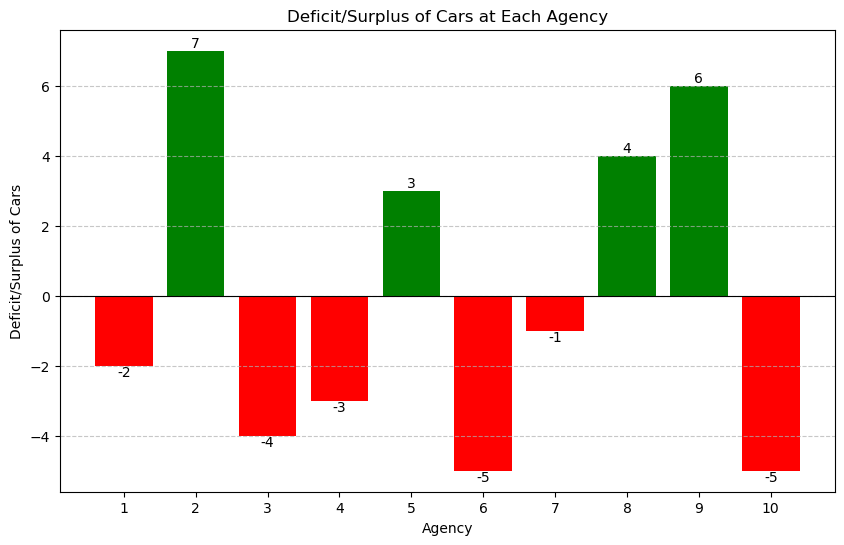

In [9]:
# Calculate deficit/surplus
deficit_surplus = [s - req for s, req in zip(p, r)]
xticks = np.arange(data.index[0], data.index[-1] + 1)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(data.index, deficit_surplus, color=np.where(np.array(deficit_surplus) >= 0, 'green', 'red'))

# Add labels and title
plt.xlabel("Agency")
plt.ylabel("Deficit/Surplus of Cars")
plt.title("Deficit/Surplus of Cars at Each Agency")
plt.axhline(0, color='black', linewidth=0.8)  # Add a horizontal line at y=0
plt.xticks(xticks)

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             f'{height:.0f}', ha='center', va='bottom' if height >= 0 else 'top')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [10]:
model = pyo.ConcreteModel("Car rental")
model.x = pyo.Var(A, B, domain=pyo.NonNegativeIntegers, doc="Quantity of cars to go from agency a to agency b")

model.objective = pyo.Objective(expr=c*sum(d.loc[a,b]*model.x[a,b] for a in A for b in B), sense=pyo.minimize,
                                doc="Minimize the total cost of transportin cars")

model.constraint_excess = pyo.ConstraintList(doc="Every agency with an excess number of cars needs to get rid of these.")
for a in A:
    model.constraint_excess.add(expr=sum(model.x[a,b] for b in B) == p[a] - r[a])

model.constraint_need = pyo.ConstraintList(doc="Every agency in need of car has to complete its fleet by receiving the missing number.")
for b in B:
    model.constraint_need.add(expr=sum(model.x[a,b] for a in A) == r[b] - p[b])

solver = pyo.SolverFactory("glpk")
results = solver.solve(model)

In [11]:
results

{'Problem': [{'Name': 'unknown', 'Lower bound': 152.639016322956, 'Upper bound': 152.639016322956, 'Number of objectives': 1, 'Number of constraints': 10, 'Number of variables': 24, 'Number of nonzeros': 48, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': '1', 'Number of created subproblems': '1'}}, 'Error rc': 0, 'Time': 0.006581783294677734}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In [12]:
model.pprint()

1 Var Declarations
    x : Quantity of cars to go from agency a to agency b
        Size=24, Index={8, 9, 2, 5}*{1, 3, 4, 6, 7, 10}
        Key     : Lower : Value : Upper : Fixed : Stale : Domain
         (2, 1) :     0 :   0.0 :  None : False : False : NonNegativeIntegers
         (2, 3) :     0 :   1.0 :  None : False : False : NonNegativeIntegers
         (2, 4) :     0 :   0.0 :  None : False : False : NonNegativeIntegers
         (2, 6) :     0 :   5.0 :  None : False : False : NonNegativeIntegers
         (2, 7) :     0 :   1.0 :  None : False : False : NonNegativeIntegers
        (2, 10) :     0 :   0.0 :  None : False : False : NonNegativeIntegers
         (5, 1) :     0 :   0.0 :  None : False : False : NonNegativeIntegers
         (5, 3) :     0 :   0.0 :  None : False : False : NonNegativeIntegers
         (5, 4) :     0 :   3.0 :  None : False : False : NonNegativeIntegers
         (5, 6) :     0 :   0.0 :  None : False : False : NonNegativeIntegers
         (5, 7) :     0

In [13]:
for a in A:
    for b in B:
        if pyo.value(model.x[a,b]) != 0:
            cars = int(pyo.value(model.x[a,b]))
            print(f"Agency {a} sends to agency {b}: {cars} cars")

Agency 2 sends to agency 3: 1 cars
Agency 2 sends to agency 6: 5 cars
Agency 2 sends to agency 7: 1 cars
Agency 5 sends to agency 4: 3 cars
Agency 8 sends to agency 10: 4 cars
Agency 9 sends to agency 1: 2 cars
Agency 9 sends to agency 3: 3 cars
Agency 9 sends to agency 10: 1 cars


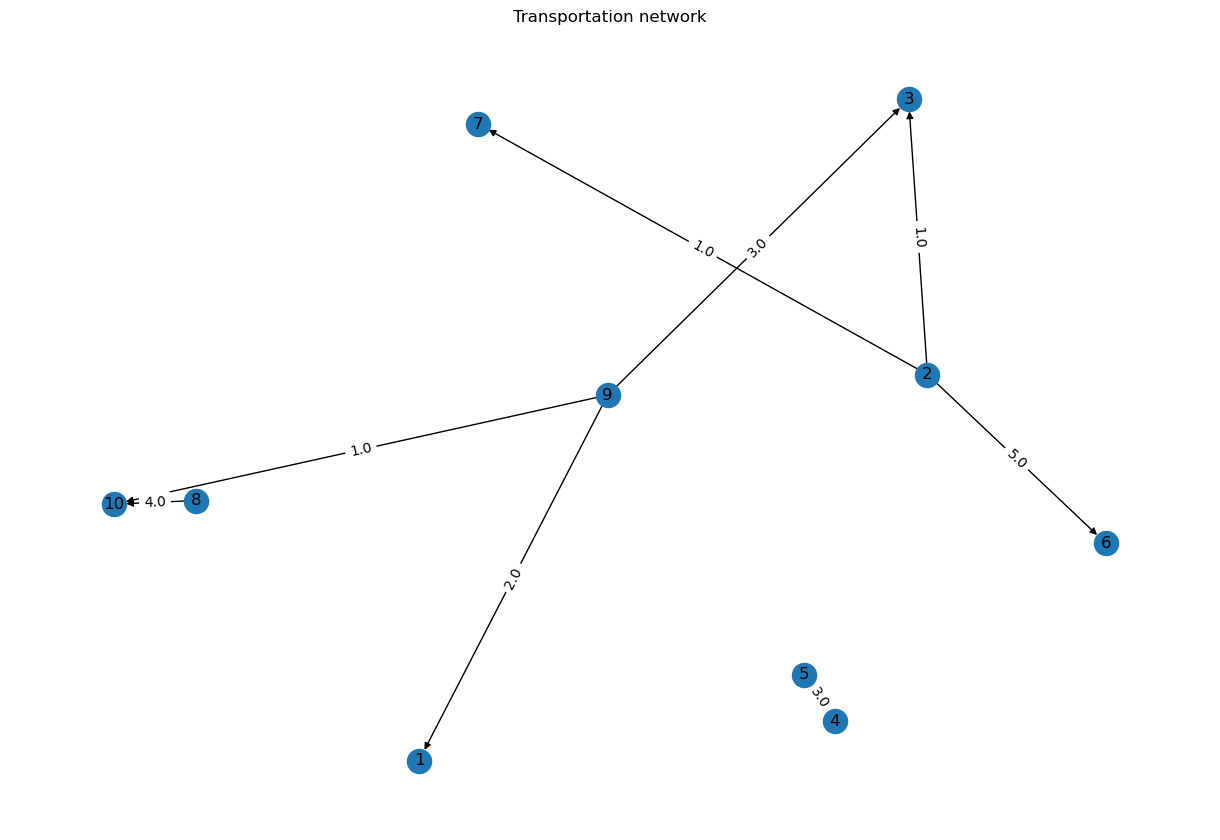

In [14]:
# Let's plot the solution as a network
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

solution = model.x.get_values()

for (source, destination), cars in solution.items():
    if solution[source, destination] != 0:
        G.add_edge(source, destination, weight=cars)

# Positioning the nodes
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, "weight")

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Transportation network")
plt.show()

In [15]:
# Costo total
print(f"Minimum cost flow: ${pyo.value(model.objective)}")

Minimum cost flow: $152.6390163229563
